(FeedForwardNeuralNetworks)=
# Feed-forward neural network

As neural networks are a pillar in both the early and the recent advances of artificial intelligence, their use for credit card fraud detection is not surprising. The first examples of simple feed-forward neural networks applied to fraud detection can bring us back to the early 90s {cite}`ghosh1994credit,aleskerov1997cardwatch`. Naturally, in recent FDS studies, neural networks are often found in experimental benchmarks, along with random forests, XGBoost, or logistic regression.

At the core of a feed-forward neural network is the artificial neuron, a simple machine learning model that consists of a linear combination of input variables followed by the application of an activation function $\sigma$ (sigmoid, ReLU, tanh, ...). More precisely, given a list of $n$ input variables $x_i$, the output $h$ of the artificial neuron is computed as follows:

$h = \sigma(\sum_{i=1}^n w_i*x_i)$

where $w_i$ are the weights of the model.

A whole network is composed of a succession of layers containing neurons that take, as inputs, the output values of the previous layer.

![A feed forward neural network architecture](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook/blob/main/Chapter_7_DeepLearning/images/neuralnetwork.png?raw=1)

When applied to the fraud detection problem, the architecture is designed as follows:

* At the beginning of the network, the neurons take as input the characteristics of a credit card transaction, i.e. the features that were defined in the previous chapters.
* At the end, the network outputs a single neuron that aims at representing the probability for the input transaction to be a fraud.

The rest of the architecture (other layers), the neurons specificity (activation functions), and other hyperparameters (optimization, data processing, ...) are left to the practitioner's choice.

The most popular training algorithm for feedforward architectures is backpropagation {cite}`hecht1992theory`. The idea is to iterate over all samples of the dataset and perform two key operations:
* the forward pass: setting the sample's features values in the input neurons and computing all the layers to finally obtain a predicted output.
* the backward pass: computing a cost function, i.e. a discrepancy between the prediction and the expected ground truth output, and trying to minimize it with an optimizer (e.g. gradient descent) by updating weights layer after layer, from output to input.

This section covers the design of a feed-foward neural network for fraud detection. It describes how to:
* Implement a first simple neural network and study the impact of several architectures and design choices.
* Wrap it to make it compatible with the model selection methodology from Chapter 5 and run a grid-search to select its optimal parameters.
* Store the important functions for a final comparison between deep learning techniques and other baselines at the end of the chapter.

Let us first start by importing all the necessary libraries and functions and retrieving the simulated data.

In [65]:
# Initialization: Load shared functions and simulated data

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63257  100 63257    0     0   128k      0 --:--:-- --:--:-- --:--:--  128k


<Figure size 640x480 with 0 Axes>

## Data Loading

The experimental setup is the same as in Chapter 5. More precisely, at the end of the chapter, model selection will be based on a grid search with multiple validations. Each time, one week of data will be used for training a neural network and one week of data for testing the predictions.

To implement the first base network and explore several architecture choices, let us start by selecting a training and validation period arbitrarily. The experiments will be based on the transformed simulated data (`simulated-data-transformed/data/`) and the same feature set as other models.

In [66]:
DIR_INPUT='simulated-data-transformed/data/'

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']

Load  files
CPU times: user 430 ms, sys: 764 ms, total: 1.19 s
Wall time: 1.19 s
919767 transactions loaded, containing 8195 fraudulent transactions


In [67]:
# Setting the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=7
delta_delay=7
delta_test=7
(train_df, test_df)=get_train_test_set(transactions_df,start_date_training,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)
# By default, scaling the input data
(train_df, test_df)=scaleData(train_df,test_df,input_features)

In [68]:
train_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
421597,1102483,2018-07-25 00:00:29,1111,2328,-0.303663,9936029,115,0,0,-0.62823,...,0.655714,-0.800291,0.934422,-0.801283,0.000248,-0.075836,1.005829,-0.11808,0.241363,-0.147825
421598,1102484,2018-07-25 00:01:08,676,6846,-1.042495,9936068,115,0,0,-0.62823,...,-0.510235,-1.129245,-0.585080,-1.206503,0.980006,-0.075836,-0.664368,-0.11808,-0.363745,-0.147825
421599,1102485,2018-07-25 00:01:35,402,4771,0.663578,9936095,115,0,0,-0.62823,...,-1.028434,4.267868,-0.964955,1.988988,-0.979511,-0.075836,1.673908,-0.11808,0.846470,-0.147825
421600,1102486,2018-07-25 00:01:43,4218,863,-0.722769,9936103,115,0,0,-0.62823,...,0.655714,-1.062067,0.520012,-1.147390,0.980006,-0.075836,-0.330328,-0.11808,-0.968852,-0.147825
421601,1102487,2018-07-25 00:02:26,3711,3599,0.134655,9936146,115,0,0,-0.62823,...,1.044364,0.878439,1.107093,0.699063,0.000248,-0.075836,1.005829,-0.11808,0.967491,-0.147825


## Overview of the neural network pipeline

The first step here is to implement a base neural network. There are several Python libraries that we can use (TensorFlow, PyTorch, Keras, MXNet, ...). In this book, the PyTorch library {cite}`paszke2017automatic` is used, but the models and benchmarks that will be developed could also be implemented with other libraries.

In [69]:
import torch

If torch and cuda libraries are installed properly, the models developed in this chapter can be trained on the GPU. For that, let us create a "DEVICE" variable and set it to "cuda" if a cuda device is available and "cpu" otherwise. In the rest of the chapter, all the models and tensors will be sent to this device for computations.

In [70]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"
print("Selected device is",DEVICE)

Selected device is cpu


To ensure reproducibility, a random seed will be fixed like in previous chapters. Additionally to setting the seed for `NumPy` and `random`, it is necessary to set it for `torch`:

In [71]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

The function `seed_everything` defined above will be run before each model initialization and training.

Before diving into the neural network implementation, let us summarize the main elements of a deep learning training/testing pipeline in Torch:
* Datasets/Dataloaders: It is recommended to manipulate data with specific PyTorch classes. [Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) is the interface to access the data. Given a sample's index, it provides a well-formed input-output for the model. [Dataloader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) takes the Dataset as input and provides an iterator for the training loop. It also allows to create batches, shuffle data, and parallelize data preparation.
* Model/Module: Any model in PyTorch is a [torch.module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). It has an init function in which it instantiates all the necessary submodules (layers) and initializes their weights. It also has a forward function that defines all the operations of the forward pass.
* The optimizer: The [optimizer](https://pytorch.org/docs/stable/optim.html) is the object that implements the optimization algorithm. It is called after the loss is computed to calculate the necessary model updates. The most basic one is SGD, but there are many others like RMSProp, Adagrad, Adam, ...
* Training loop and evaluation: the training loop is the core of a model's training. It consists in performing several iterations (epochs), getting all the training batches from the loader, performing the forward pass, computing the loss, and calling the optimizer. After each epoch, an evaluation can be performed to track the model's evolution and possibly stop the process.

The next subsections describe and implement in details each of these elements.

### Data management: Datasets and Dataloaders

The first step is to convert our data into objects that PyTorch can use, like `FloatTensors`.

In [72]:
x_train = torch.FloatTensor(train_df[input_features].values)
x_test = torch.FloatTensor(test_df[input_features].values)
y_train = torch.FloatTensor(train_df[output_feature].values)
y_test = torch.FloatTensor(test_df[output_feature].values)

Next comes the definition of a custom `Dataset`. This dataset is initialized with `x_train`/`x_test` and `y_train`/`y_test` and returns the individual samples in the format required by our model, after sending them to the right device.

In [73]:
class FraudDataset(torch.utils.data.Dataset):

    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y

    def __len__(self):
        'Returns the total number of samples'
        return len(self.x)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample index
        if self.y is not None:
            return self.x[index].to(DEVICE), self.y[index].to(DEVICE)
        else:
            return self.x[index].to(DEVICE)

Note: This first custom Dataset `FraudDataset` seems useless because its role is very limited (simply returning a row from x and y) and because the matrices x and y are already loaded in RAM. This example is provided for educational purposes. But the concept of Dataset has a high interest when sample preparation requires more preprocessing. For instance, it becomes very handy for sequence preparation when using recurrent models (like an LSTM). This will be covered more in-depth later in this chapter but for example, a Dataset for sequential models performs several operations before returning a sample: searching for the history of transactions of the same cardholder and appending it to the current transaction before returning the whole sequence. It avoids preparing all the sequences in advance, which would entail repeating several transactions' features in memory and consuming more RAM than necessary. Datasets objects are also useful when dealing with large image datasets in order to load the images on the fly.

Now that `FraudDataset` is defined, one can choose the training/evaluation parameters and instantiate DataLoaders. For now, let us consider a batch size of 64: this means that at each optimization step, 64 samples will be requested to the Dataset, turned into a batch, and go through the forward pass in parallel. Then the aggregation (sum or average) of the gradient of their losses will be used for backpropagation.

For the training DataLoader, the shuffle option will be set to `True` so that the order of the data seen by the model will not be the same from one epoch to another. This is recommended and known to be beneficial in Neural Network training {cite}`ruder2016overview`.

In [74]:
train_loader_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 0}
test_loader_params = {'batch_size': 64,
          'num_workers': 0}

# Generators

training_set = FraudDataset(x_train, y_train)

testing_set = FraudDataset(x_test, y_test)


training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
testing_generator = torch.utils.data.DataLoader(testing_set, **test_loader_params)

The `num_workers` parameter allows parallelizing batch preparation. It can be useful when the `Dataset` requires a lot of processing before returning a sample. Here we do not use multiprocessing so we set `num_workers` to 0.

### The model aka the module

After defining the data pipeline, the next step is to design the module. Let us start with a first rather simple feed-forward neural network.

As suggested in the introduction, the idea is to define several fully connected layers (`torch.nn.Linear`). A first layer `fc1` which takes as input as many neurons as there are features in the input x. It can be followed by a hidden layer with a chosen number of neurons (`hidden_size`). Finally comes the output layer which has a single output neuron to fit the label (`fraud` or `genuine`, represented by 1 and 0).

In the past, the sigmoid activation function used to be the primary choice for all activation functions in all layers of a neural network. Today, the preferred choice is `ReLU` (or variants like `eLU`, `leaky ReLU`), at least for the intermediate neurons. It has empirically proven to be a better choice for optimization and speed {cite}`nair2010rectified`. For output neurons, the choice depends on the range or the expected distribution for the output value to be predicted.

Below are plotted the output of several activation functions with respect to their input value to show how they behave and how they are distributed:

In [75]:
%%capture

fig_activation, axs = plt.subplots(3, 2,figsize=(11, 13))

input_values = torch.arange(-5, 5, 0.05)

#linear activation
output_values = input_values
axs[0, 0].plot(input_values, output_values)
axs[0, 0].set_title('Linear')
axs[0, 0].set_ylim([-5.1,5.1])

#heavyside activation
output_values = input_values>0
axs[0, 1].plot(input_values, output_values)
axs[0, 1].set_title('Heavyside (perceptron)')
axs[0, 1].set_ylim([-0.1,1.1])

#sigmoid activation
activation = torch.nn.Sigmoid()
output_values = activation(input_values)
axs[1, 0].plot(input_values, output_values)
axs[1, 0].set_title('Sigmoid')
axs[1, 0].set_ylim([-1.1,1.1])

#tanh activation
activation = torch.nn.Tanh()
output_values = activation(input_values)
axs[1, 1].plot(input_values, output_values)
axs[1, 1].set_title('Tanh')
axs[1, 1].set_ylim([-1.1,1.1])

#relu activation
activation = torch.nn.ReLU()
output_values = activation(input_values)
axs[2, 0].plot(input_values, output_values)
axs[2, 0].set_title('ReLU')
axs[2, 0].set_ylim([-0.5,5.1])

#leaky relu activation
activation = torch.nn.LeakyReLU(negative_slope=0.05)
output_values = activation(input_values)
axs[2, 1].plot(input_values, output_values)
axs[2, 1].set_title('Leaky ReLU')
axs[2, 1].set_ylim([-0.5,5.1])

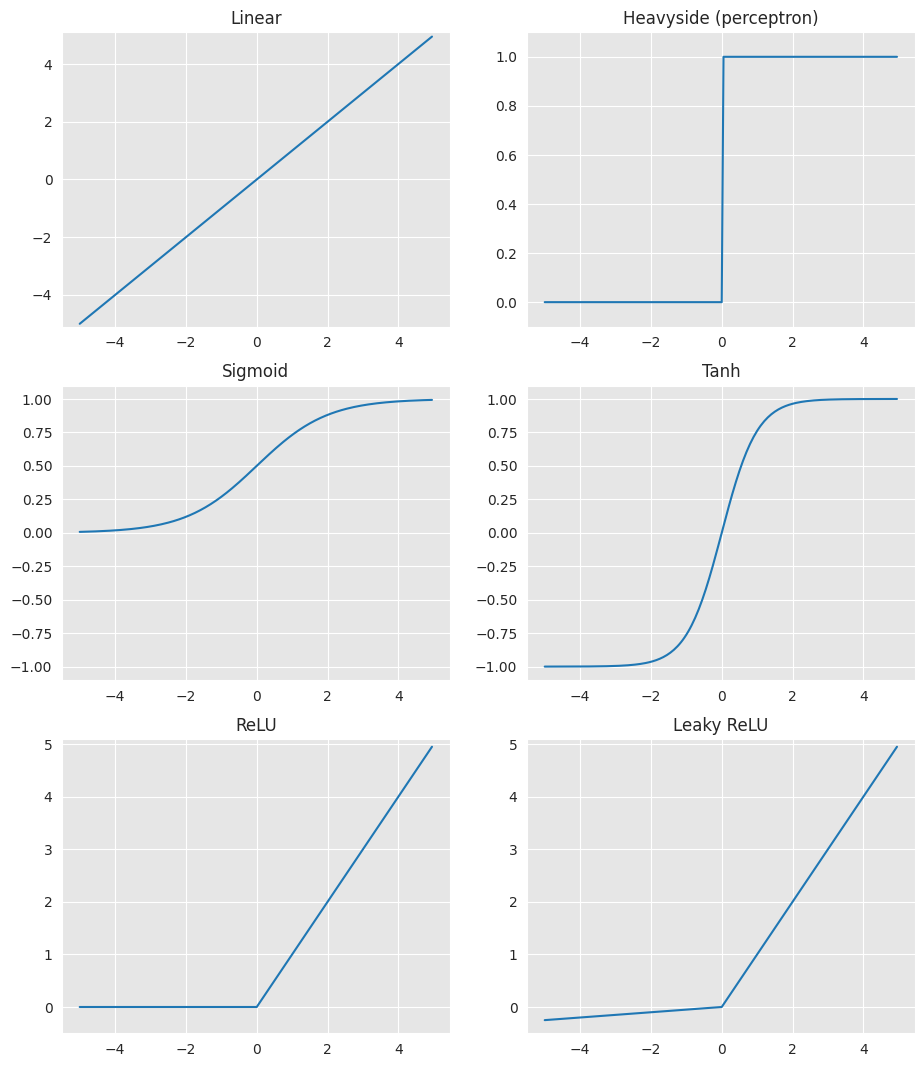

In [76]:
fig_activation

For our fraud detection neural network, the `ReLU` activation will be used for the hidden layer and a `Sigmoid` activation for the output layer. The first is the primary choice for intermediate layers in deep learning. The latter is the primary choice for the output neurons in binary classification problems because it outputs values between 0 and 1 that can be interpreted as probabilities.

To implement this, let us create a new class `SimpleFraudMLP` that will inherit from a torch module. Its layers (`fc1`, `relu`, `fc2`, `sigmoid`) are initialized in the `__init__` function and will be used successively in the forward pass.  

In [77]:
class SimpleFraudMLP(torch.nn.Module):

        def __init__(self, input_size, hidden_size):
            super(SimpleFraudMLP, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size

            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, x):

            hidden = self.fc1(x)
            relu = self.relu(hidden)
            output = self.fc2(relu)
            output = self.sigmoid(output)

            return output

Once defined, instantiating the model with `1000` neurons in its hidden layer and sending it to the device can be done as follows:

In [78]:
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

### The optimizer and the training loop

Optimization is at the core of neural network training. The above neural network is designed to output a single value between 0 and 1. The goal is that this value gets as close to 1 (resp. 0) as possible for an input describing a fraudulent (resp. genuine) transaction.

In practice, this goal is formulated with an optimization problem that aims at minimizing or maximizing some cost/loss function. The role of the loss function is precisely to measure the discrepancy between the predicted value and the expected value (0 or 1), also referred to as the ground truth. There are many loss functions (mean squared error, cross-entropy, KL-divergence, hinge loss, mean absolute error) available in PyTorch, and each serves a specific purpose. Here we only focus on binary cross-entropy because it is the most relevant loss function for binary classification problems like fraud detection. It is defined as follows:

$BCE(y,p) = −(y*log(p)+(1−y)*log(1−p))$

Where $y$ is the ground truth (in $\{0,1\}$) and $p$ the predicted output (in $]0,1[$).

In [79]:
criterion = torch.nn.BCELoss().to(DEVICE)

Note: Pushing the criterion to the device is only required if this one stores/updates internal state variables or has parameters. It is unnecessary but not detrimental in the above case. We do it to show the most general implementation.

Before even training the model, one can already measure its initial loss on the testing set. For this, the model has to be put in `eval` mode:

In [80]:
model.eval()

SimpleFraudMLP(
  (fc1): Linear(in_features=15, out_features=1000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Then, the process consists in iterating over the testing generator, making predictions, and evaluating the chosen `criterion` (here `torch.nn.BCELoss`)

In [81]:
def evaluate_model(model,generator,criterion):
    model.eval()
    batch_losses = []
    for x_batch, y_batch in generator:
        # Forward pass
        y_pred = model(x_batch)
        # Compute Loss
        loss = criterion(y_pred.squeeze(), y_batch)
        batch_losses.append(loss.item())
    mean_loss = np.mean(batch_losses)
    return mean_loss

evaluate_model(model,testing_generator,criterion)

0.6754083204871344

Recall that the optimization problem is defined as follows: minimize the total/average binary cross-entropy of the model over all samples from the training dataset. Therefore, training the model consists in applying an optimization algorithm (backpropagation) to numerically solve the optimization problem.

The optimization algorithm or `optimizer` can be the standard stochastic gradient descent with a constant learning rate (`torch.optim.SGD`) or with an adaptive learning rate (`torch.optim.Adagrad`, `torch.optim.Adam`, etc...). Several optimization hyperparameters (learning rate, momentum, batch size, ...) can be tuned. Note that choosing the right optimizer and hyperparameters will impact convergence speed and the quality of the reached optimum. Below is an illustration showing how fast different optimizers can reach the optimum (represented with a star) of a two dimensional optimization problem over the training process.

![Optimizers convergence](https://ml-cheatsheet.readthedocs.io/en/latest/_images/optimizers.gif)

Source: https://cs231n.github.io/neural-networks-3/


Here, let us start with the arbitrary choice `SGD`, with a learning rate of `0.07`.

In [82]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.07)

And let us implement the training loop for our neural network. First, the model has to be set in training mode. Then several iterations can be performed over the training generator (each iteration is called an epoch). During each iteration, a succession of training batches are provided by the generator and a forward pass is performed to get the model's predictions. Then the criterion is computed between predictions and ground truth, and finally, the backward pass is carried out to update the model with the optimizer.
Let us start by setting the number of epochs to `150` arbitrarily.

In [83]:
n_epochs = 100
#Setting the model in training mode
model.train()

#Training loop
start_time=time.time()
epochs_train_losses = []
epochs_test_losses = []
for epoch in range(n_epochs):
    model.train()
    train_loss=[]
    for x_batch, y_batch in training_generator:
        # Removing previously computed gradients
        optimizer.zero_grad()
        # Performing the forward pass on the current batch
        y_pred = model(x_batch)
        # Computing the loss given the current predictions
        loss = criterion(y_pred.squeeze(), y_batch)
        # Computing the gradients over the backward pass
        loss.backward()
        # Performing an optimization step from the current gradients
        optimizer.step()
        # Storing the current step's loss for display purposes
        train_loss.append(loss.item())

    #showing last training loss after each epoch
    epochs_train_losses.append(np.mean(train_loss))
    print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))

    #evaluating the model on the test set after each epoch
    val_loss = evaluate_model(model,testing_generator,criterion)
    epochs_test_losses.append(val_loss)
    print('test loss: {}'.format(val_loss))
    print("")

training_execution_time=time.time()-start_time

Epoch 0: train loss: 0.03570016137555553
test loss: 0.022358749608757663

Epoch 1: train loss: 0.026285224329887558
test loss: 0.021145284218298584

Epoch 2: train loss: 0.024935485474915055
test loss: 0.021621913086105667

Epoch 3: train loss: 0.024153651457171812
test loss: 0.020166814625626132

Epoch 4: train loss: 0.023543032519470593
test loss: 0.020734394968995408

Epoch 5: train loss: 0.02311610374420254
test loss: 0.02028386041309386

Epoch 6: train loss: 0.022610568783829055
test loss: 0.01981479125151065

Epoch 7: train loss: 0.022428529804371312
test loss: 0.021500718789318276

Epoch 8: train loss: 0.021857453960651526
test loss: 0.02204068632897104

Epoch 9: train loss: 0.021729045080776006
test loss: 0.02033687148125112

Epoch 10: train loss: 0.021540807152798772
test loss: 0.019787190465152295

Epoch 11: train loss: 0.021363750270272753
test loss: 0.019339693427028626

Epoch 12: train loss: 0.0210939898025147
test loss: 0.02080311853506088

Epoch 13: train loss: 0.0208563

KeyboardInterrupt: 

After training the model, a good practice is to analyze the training logs.

In [ ]:
ma_window = 10

plt.plot(np.arange(len(epochs_train_losses)-ma_window + 1)+1, np.convolve(epochs_train_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.plot(np.arange(len(epochs_test_losses)-ma_window + 1)+1, np.convolve(epochs_test_losses, np.ones(ma_window)/ma_window, mode='valid'))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
#plt.ylim([0.01,0.06])

In [ ]:
print(training_execution_time)

One can note here how the training loss decreases epoch after epoch. This means that the optimization is going well: the chosen learning rate allows to update the model towards a better solution (lower loss) for the **training dataset**. However, neural networks are known to be very expressive models. In fact, the universal approximation theorem shows that, with enough neurons/layers, one can model any function with a neural network {cite}`cybenko1989approximation`. Therefore, it is expected for a complex neural network to be able to fit almost perfectly the training data. But the ultimate goal is to obtain a model that generalizes well on unseen data (like the validation set). Looking at the validation loss, one can see that it starts by decreasing (with oscillations) and it reaches an optimum around 0.019, and stops decreasing (or even starts increasing). This phenomenon is referred to as [overfitting](Model_Selection).

Many aspects can be improved in the training. Although one cannot measure the performance on the final test set while training, one can rely on a validation set and try to stop training before overfitting (see [](Model_Selection)). One can also change the optimization algorithm and parameters to speed up training and reach a better optimum. This is investigated later, in the optimization paragraph.

For now, let us consider this final fitted model and evaluate it the same way as the other models in previous chapters. For this, let us create a prediction DataFrame and call the `performance_assessment` function from the shared functions.

In [ ]:
start_time=time.time()
predictions_test = model(x_test.to(DEVICE))
prediction_execution_time = time.time()-start_time
predictions_train = model(x_train.to(DEVICE))
print("Predictions took", prediction_execution_time,"seconds.")

In [ ]:
predictions_df=test_df
predictions_df['predictions']=predictions_test.detach().cpu().numpy()

performance_assessment(predictions_df, top_k_list=[100])

This first shot feed-forward network already obtains a decent performance on the test set (refer to [Chapter 3.4](Baseline_FDS_Performances_Simulation) for comparison). But several elements can be modified to improve the AUC ROC, reduce the training time, etc.

As stated above, for the first model, optimization was not carried out properly because the validation performance is not exploited during the training process. To avoid overfitting in practice, it is necessary to take it into account (See Chapter 5, [](Hold_Out_Validation)).

In [ ]:
delta_valid = delta_test

start_date_training_with_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))

(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

# By default, scales input data
(train_df, valid_df)=scaleData(train_df, valid_df, input_features)

Let us implement an early stopping strategy. The idea is to detect overfitting, i.e. when validation error starts increasing, and stop the training process. Sometimes, the validation error might increase at a given epoch, but then decrease again. For that reason, it is important to also consider a patience parameter, i.e. a number of iterations for which the training process waits in order to make sure that the error is definitely increasing.

In [ ]:
class EarlyStopping:

    def __init__(self, patience=2, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = np.Inf

    def continue_training(self,current_score):
        if self.best_score > current_score:
            self.best_score = current_score
            self.counter = 0
            if self.verbose:
                print("New best score:", current_score)
        else:
            self.counter+=1
            if self.verbose:
                print(self.counter, " iterations since best score.")

        return self.counter <= self.patience

In [ ]:
seed_everything(SEED)

model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)

def prepare_generators(train_df,valid_df,batch_size=64):
    x_train = torch.FloatTensor(train_df[input_features].values)
    x_valid = torch.FloatTensor(valid_df[input_features].values)
    y_train = torch.FloatTensor(train_df[output_feature].values)
    y_valid = torch.FloatTensor(valid_df[output_feature].values)
    train_loader_params = {'batch_size': batch_size,
              'shuffle': True,
              'num_workers': 0}
    valid_loader_params = {'batch_size': batch_size,
              'num_workers': 0}
    # Generators

    training_set = FraudDataset(x_train, y_train)
    valid_set = FraudDataset(x_valid, y_valid)

    training_generator = torch.utils.data.DataLoader(training_set, **train_loader_params)
    valid_generator = torch.utils.data.DataLoader(valid_set, **valid_loader_params)

    return training_generator,valid_generator

training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

criterion = torch.nn.BCELoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.0005)

The training loop can now be adapted to integrate early stopping:

In [ ]:
def training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=100,apply_early_stopping=True,patience=2,verbose=False):
    #Setting the model in training mode
    model.train()

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=verbose,patience=patience)

    all_train_losses = []
    all_valid_losses = []

    #Training loop
    start_time=time.time()
    for epoch in range(max_epochs):
        model.train()
        train_loss=[]
        for x_batch, y_batch in training_generator:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        #showing last training loss after each epoch
        all_train_losses.append(np.mean(train_loss))
        if verbose:
            print('')
            print('Epoch {}: train loss: {}'.format(epoch, np.mean(train_loss)))
        #evaluating the model on the test set after each epoch
        valid_loss = evaluate_model(model,valid_generator,criterion)
        all_valid_losses.append(valid_loss)
        if verbose:
            print('valid loss: {}'.format(valid_loss))
        if apply_early_stopping:
            if not early_stopping.continue_training(valid_loss):
                if verbose:
                    print("Early stopping")
                break

    training_execution_time=time.time()-start_time
    return model,training_execution_time,all_train_losses,all_valid_losses

model,training_execution_time,train_losses,valid_losses = training_loop(model,training_generator,valid_generator,optimizer,criterion,max_epochs=500,verbose=True)

After 251 epochs, the model stops learning because the validation performance has not improved for three iterations. Here the optimal model (from epoch 248) is not saved, but this could be implemented by simply adding `torch.save(model.state_dict(), checkpoint_path)` in the `EarlyStopping` class whenever a new best performance is reached. This allows reloading the saved best checkpoint at the end of the training.

Now that a clean optimization process is defined, one can consider several solutions to speed up and improve convergence towards a decent extremum. The most natural way to do so is to play with the optimizer hyperparameters like the learning rate and the batch size. With a large learning rate, gradient descent is fast at the beginning, but then the optimizer struggles to find the minimum. Adaptive learning rate techniques like Adam/RMSProp take into account the steepness by normalizing the learning rate with respect to the gradient norm. Below are the formulas to update on a model parameter $w_t$ with Adam.

$w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v_t}+\epsilon}}*\hat{m_t}$

Where:

$m_t = \beta_1 * m_{t-1} + (1-\beta_1)*\nabla w_t$

$v_t = \beta_2 * v_{t-1} + (1-\beta_2)*(\nabla w_t)^2$

$\hat{m_t}=\frac{m_t}{1-\beta_1^t}$

$\hat{v_t}=\frac{v_t}{1-\beta_2^t}$

The difference with SGD is that here the learning rate is normalized using the "gradient norm" ($\approx \hat{m_t}$). To be more precise, the approach does not use the "raw" gradient $\nabla w_t$ and gradient norm $\nabla w_t^2$ but a momentum instead (convex combination between previous values and the current value), respectively $m_t$ and $v_t$. It also applies a decay over the iterations.

Let us try Adam with an initial learning rate of `0.0005` to see the difference with regular SGD.

In [ ]:
seed_everything(SEED)
model = SimpleFraudMLP(len(input_features), 1000).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_adam,valid_losses_adam = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=True)

In [ ]:


plt.subplot(1, 2, 2)
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.title("ADAM")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

plt.subplot(1, 2, 1)
plt.plot(np.arange(len(train_losses))+1, train_losses)
plt.plot(np.arange(len(valid_losses))+1, valid_losses)
plt.title("SGD")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','valid'])
plt.ylim([0.01,0.06])

The optimization is much faster with Adam (10 times fewer epochs) and it reaches a better optimum. Of course, increasing patience or changing the learning rate with SGD would probably help improve both speed and optimum. Nevertheless, Adam will be retained for the rest of the chapter as it usually allows very decent performance **without significant tuning**. To build the final neural network later, the tuning will mostly be made using batch size and initial learning rate.

Here are only mentioned the optimizer's choice and some hyperparameters tuning for the optimization process. But keep in mind that neural network optimization is a very wide and active area of research/engineering. For instance, with Deep Networks, one can apply batch normalization after each layer to standardize the distribution and speed up convergence. One can also reduce the learning rate when validation loss reaches a plateau (`torch.optim.ReduceLROnPlateau`). For a full guide on Deep Learning optimization, we recommend {cite}`ruder2016overview,le2011optimization`.

## Regularization

A classical way to improve generalization and reach a better validation performance is to regularize the model. Roughly speaking, regularization consists in limiting the model expressiveness in order to reduce overfitting.

The most common technique to regularize a machine learning model is to restrict its parameter space, for instance, its norm, by adding a term in the optimization problem. Additionally, to minimize the discrepancy between ground truth and prediction, integrating an L1 norm (resp. L2 norm) term in the loss will entail parameter sparsity (resp. will limit parameters amplitude). The initial solution space is generally full of equivalent solutions (e.g. with linear activations, dividing all input weights of a neuron by 2 and multiplying all of its output weights by 2 leads to an equivalent model), so the restrictions entailed by regularization not only limits overfitting but also reduces the search and can help with optimization. Finally, selecting a solution with minimal norm follows the principle of "All things being equal, the simplest solution tends to be the best one", a scientific principle often referred to as the [Occam's razor](https://en.wikipedia.org/wiki/Occam's_razor).

In contrast to adding loss terms, there is a regularization technique specifically designed for Neural Networks called dropout. Dropout consists in randomly dropping some neurons from the network at each training step. More precisely, one fixes a dropout parameter p∈[0,1], and, for each mini-batch, for each neuron, performs a coin toss (Bernoulli) with probability p. If positive, one temporarily sets the neuron's weights to zero (so that the dropped neuron is not considered during the forward and backward passes). It is equivalent to training a random sub-network at each mini-batch (Figure 5), and it can be proven that this has an L2-regularization effect on specific architectures {cite}`srivastava2014dropout`.

![alt text](https://github.com/Fraud-Detection-Handbook/fraud-detection-handbook/blob/main/Chapter_7_DeepLearning/images/dropout.png?raw=1)
Image source: {cite}`srivastava2014dropout`

To implement it, let us define a new model with an additional `torch.nn.Dropout` layer.

In [ ]:
class SimpleFraudMLPWithDropout(torch.nn.Module):

        def __init__(self, input_size, hidden_size,p):
            super(SimpleFraudMLPWithDropout, self).__init__()
            # parameters
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.p = p

            #input to hidden
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            #hidden to output
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()

            self.dropout = torch.nn.Dropout(self.p)

        def forward(self, x):

            hidden = self.fc1(x)
            hidden = self.relu(hidden)

            hidden = self.dropout(hidden)

            output = self.fc2(hidden)
            output = self.sigmoid(output)

            return output

Note that setting the model in training/evaluation mode with the methods `model.eval()` and `model.train()` take all its significance here. In particular, the dropout layer in the forward pass is only applied when the model is in training mode.

In [ ]:
seed_everything(SEED)
model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
model,training_execution_time,train_losses_dropout,valid_losses_dropout = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

In [ ]:
plt.plot(np.arange(len(train_losses_adam))+1, train_losses_adam)
plt.plot(np.arange(len(valid_losses_adam))+1, valid_losses_adam)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title("Dropout effect")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o dropout','valid w/o dropout','train w/ dropout','valid w/ dropout'])

It is generally reported that a small dropout value can lead to better generalization results than no dropout, but it can sometimes be the opposite if the training data are very rich, if the training distribution is close to the valid/test distribution, and if the model is already not too expressive. So, the best practice is to consider dropout as a hyperparameter (that could be set to 0) and tune it with a hyperparameter search.

In addition to the L2-regularization effect, dropout can be seen as a very powerful mechanism that mimics ensembling strategies like bagging (the model can be seen as an ensemble of submodels trained on different subsets of data) {cite}`goodfellow2016deep`.

## Scaling the inputs

XGBoost and random forests learn splits on single features and therefore are robust to the scale and distribution of the values. On the contrary, in a neural network, each neuron of the first layer learns a linear combination of all the features. Therefore, it is easier to train the neurons when all features have the same range and are normally distributed. The first property can be easily implemented by applying min-max or standard scaling on the features. As for the second property, it depends on the original distribution of the features. Some of them are not normally distributed and have non-linear scales (e.g. amount): increasing the amount by 5 dollars should not have the same effect if the starting point is 5 dollars or if the starting point is 100 dollars. It turns out that applying the log function on such features can make their distribution slightly more normal which makes it easier for feed-forward neural networks to learn from them.

In [ ]:
(train_df, valid_df)=get_train_test_set(transactions_df,start_date_training_with_valid,
                                       delta_train=delta_train,delta_delay=delta_delay,delta_test=delta_test)

For instance here is how the original amounts look like:

In [ ]:
_ = plt.hist(train_df['TX_AMOUNT'].values,bins=20)

And now let us apply the log function to it. To obtain a positive log for the feature that is in [0,+∞[, an idea is to add 1 and then apply the log function (which is equivalent to applying the `log1p` function in `numpy`). This leads to a preprocessed feature that belongs to [0,+∞[ and it can then be standardized. Here is how the amounts are distributed after all these steps:

In [ ]:
_ = plt.hist(sklearn.preprocessing.StandardScaler().fit_transform(np.log1p(train_df['TX_AMOUNT'].values).reshape(-1, 1)),bins=20)

Note that here, our artificial data were generated with Gaussians so the `np.log1p` is not very useful in practice. But keep in mind that on real-world data, the original scale of features like amount is far from normally distributed and this operation turns out to be quite often useful.

Let us forget about the log for now and just analyze the impact of scaling the features on our Neural Network's training. More precisely, let us see the difference between no scaling at all and standard scaling. A smaller learning rate of `0.0001` will be chosen here for the experiment without scaling to avoid divergence.

In [ ]:
#we did not call the function scaleData this time
seed_everything(SEED)
training_generator,valid_generator = prepare_generators(train_df,valid_df,batch_size=64)

model = SimpleFraudMLPWithDropout(len(input_features), 1000,0.2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
model,training_execution_time,train_losses_without_scaling,valid_losses_without_scaling = training_loop(model,training_generator,valid_generator,optimizer,criterion,verbose=False)

In [ ]:
plt.plot(np.arange(len(train_losses_without_scaling))+1, train_losses_without_scaling)
plt.plot(np.arange(len(valid_losses_without_scaling))+1, valid_losses_without_scaling)
plt.plot(np.arange(len(train_losses_dropout))+1, train_losses_dropout)
plt.plot(np.arange(len(valid_losses_dropout))+1, valid_losses_dropout)
plt.title('Scaling effect')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train w/o scaling','valid w/o scaling','train w/ scaling','valid w/ scaling'])

The train/valid losses are smoother and reach much better levels faster when the data is normalized with standard scaling.

In [ ]:
# Let us rescale data for the next parts
(train_df, valid_df)=scaleData(train_df, valid_df,input_features)

## Benchmark summary

Let us finally retrieve the performance results obtained in [Chapter 5](Model_Selection_Comparison_Performances) with decision tree, logistic regression, random forest and XGBoost, and compare them with those obtained with a feed-forward neural network. The results can be retrieved by loading the `performances_model_selection.pkl` and `performances_model_selection_nn.pkl` pickle files, and summarized with the `get_summary_performances` function.

In [ ]:
# Load performance results for decision tree, logistic regression, random forest and XGBoost
filehandler = open('../Chapter_5_ModelValidationAndSelection/performances_model_selection.pkl', 'rb')
(performances_df_dictionary, execution_times) = pickle.load(filehandler)

# Load performance results for feed-forward neural network
filehandler = open('performances_model_selection_nn.pkl', 'rb')
(performances_df_dictionary_nn, execution_times_nn) = pickle.load(filehandler)


In [ ]:
print('So far so good')

In [ ]:
performances_df_dt=performances_df_dictionary['Decision Tree']
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")

performances_df_lr=performances_df_dictionary['Logistic Regression']
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")

performances_df_rf=performances_df_dictionary['Random Forest']
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")

performances_df_xgboost=performances_df_dictionary['XGBoost']
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")

performances_df_nn=performances_df_dictionary_nn['Neural Network']
summary_performances_nn=get_summary_performances(performances_df_nn, parameter_column_name="Parameters summary")

summary_test_performances = pd.concat([summary_performances_dt.iloc[2,:],
                                       summary_performances_lr.iloc[2,:],
                                       summary_performances_rf.iloc[2,:],
                                       summary_performances_xgboost.iloc[2,:],
                                       summary_performances_nn.iloc[2,:],
                                      ],axis=1)

summary_test_performances.columns=['Decision Tree', 'Logistic Regression', 'Random Forest', 'XGBoost', 'Neural Network']


The results are summarized in a `summary_test_performances` table. Rows provide the average performance results on the test sets in terms of AUC ROC, Average Precision and CP@100.

In [ ]:
summary_test_performances

Overall, it appears that our simple feed-forward neural network is a good competitor in terms of predictive performance for the fraud detection problem, providing the best performances in terms of AUC ROC and CP@100, and competitive performances in terms of Average Precision. Moreover, it benefits from many advantages (e.g. its ability for incremental learning), as mentioned in the previous section.



```
# This is formatted as code
```

# Adversarial Attacks



```
# This is formatted as code
```

# White Box Attacks


In [ ]:
!pip install adversarial-robustness-toolbox


In [ ]:
from art.att

# Black Box Attacks


# Random Attack
